In [5]:
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, twitter_samples
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
import operator
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
##nltk.download('stopwords')
##nltk.download('twitter_samples')

# Twiiter API Ahthentication

In [3]:
import tweepy
from tweepy import OAuthHandler

#Register a Twitter App and add the authentication and authorisation below to be able to use tweepy

consumer_key = 'fake_consumer_key' 
consumer_secret = 'fake_consumer_secret'
access_token = 'fake_access_token'
access_secret = 'fake_access_secret'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

# Data Extraction (training set)
The emojis  :D  :)  :-)  :-D  has been queried to represnt positive tweets 

The emojis  :(  :'(  ;-(  ;(  has been queried to represnt negative tweets

refer to figure 1 of [19]

We queried tweets in London with a radius of 200 Km. refer to [22] for geocode parameter

In [ ]:
# Writing the tweets in a file in Json format
with open('training_set_Lodon.json', 'a') as f :
    for tweet in tweepy.Cursor(api.search, q=";(",rpp=100, lang="en", geocode="51.507351,-0.127758,200Km").items(5000):
        f.write(json.dumps(tweet._json) + '\n')  

# Data Exploration

In [33]:
# read positive tweets
with open('training_set_London.json', 'r') as f :
    training_tweets_positive = [json.loads(line)['text'] for line in f]

#read negative tweets
with open('training_set_London_neg.json', 'r') as f :
    training_tweets_negative = [json.loads(line)['text'] for line in f]

# mergre the two categories in one String
all_tweets = [' '.join(training_tweets_positive + training_tweets_negative)]

# create the object CountVectorizer
vectorizer = CountVectorizer()

# tokenize and build vocabulary
vectorizer.fit(all_tweets)

# encode document
vector = vectorizer.transform(all_tweets)

1


In [34]:
# words' vocabulary are sorted ascendingly with respect to their Ids (values in the dictionary)
# We get a list of tuples sorted
sorted_vocabulary = sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))
#Convert to list by taking only the words
vocabulary = [value for (value,key) in sorted_vocabulary]

## Data visualisation 

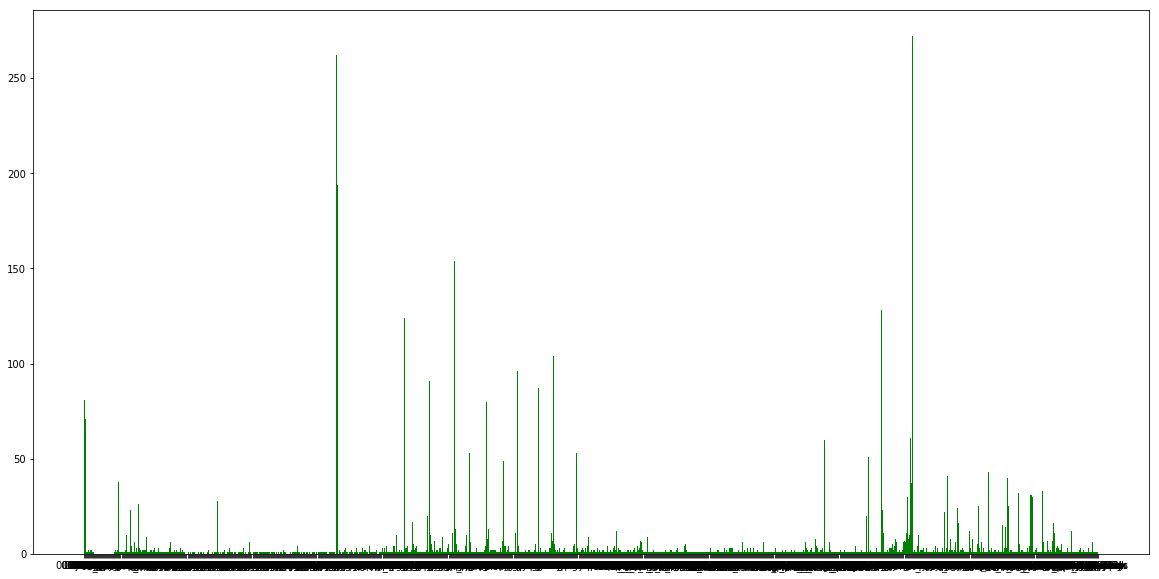

In [58]:
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(vocabulary[:1000], weights = vector.toarray()[0][:1000], facecolor='green', bins=1000)

# Data pre-processing and preparation

This part is devided into two parts : 

1. data cleaning for Naive bayes classifier :
We remove the Stop words, links, hashtags, user tags, punctuations and all words with a lenght smaller than 2, because for this classifer will be based on the most apearing words and these words apear frequently but they are meaningless in terms of sentiment analysis


2. data cleaning for SVM and logistic regression :
these classifiers use tfidf technique for features weightening which will remove the most apearing words automatically (more explanation in the report). hence we will remove only the hastags users' tags.

The 'clean' function allows us to clean the dataset depeding on each case by changing the parameters :

* stop_words = True => remove Stop words
* hashtags = list of hastags  => remove hashtags from tweet
* user_mentions = list users' tag = > remove users' tag from tweet

In [6]:
STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS.update(['https','http','RT','...'])

In [7]:
def clean(tweetText,stop_words = True, hashtags=None, user_mentions=None):
    black_list = [] ## append haghtags and user tags to remove them
    
    if hashtags != None:
        for hasch in hashtags:
             black_list.append(hasch['text'])
    
    if (user_mentions != None and user_mentions != []):
        for user in user_mentions:
            black_list.append(user['screen_name'])
    
    text_tokenised = word_tokenize(tweetText) # list of lists of words
    tweet_cleaned = []
    
    if stop_words :
        for word in text_tokenised:
            if (word not in black_list) and ('//' not in word) and (len(word) > 2) and (word not in STOP_WORDS):
                tweet_cleaned.append(word)
    else : 
        for word in text_tokenised:
            if (word not in black_list) and ('//' not in word) and (len(word) > 2) :
                tweet_cleaned.append(word)
        
    
    return tweet_cleaned

### Cleaning for SVM and Logistic Regression

In [94]:
# read and clean positive tweets from file 
with open('training_set_London.json', 'r') as f :
     tweets_positive = [' '.join( clean(json.loads(line)["text"], False, json.loads(line)["entities"]["hashtags"], json.loads(line)['entities']['user_mentions']) ) for line in f]

#read and clean negative tweets from file
with open('training_set_London_neg.json', 'r') as f :
     tweets_negative = [' '.join(clean(json.loads(line)["text"],False, 
                                json.loads(line)["entities"]["hashtags"],
                                json.loads(line)['entities']['user_mentions'])) for line in f]

### Cleaning for Naive Bayes

Extract negative and postive tweet's text, clean them and label them and create a list of all words cleaned for further usage

In [75]:
all_words = []

with open('training_set_London.json', 'r') as f :
    training_pos_tweets = [( ' '.join(clean(json.loads(line)["text"], True, json.loads(line)["entities"]["hashtags"],json.loads(line)['entities']['user_mentions'])) , 'pos') for line in f]

with open('training_set_London.json', 'r') as f :
    for line in f:
        all_words.extend(clean(json.loads(line)["text"], True))

with open('training_set_London_neg.json', 'r') as f :
    training_neg_tweets = [(' '.join(clean(json.loads(line)["text"], True, json.loads(line)["entities"]["hashtags"],json.loads(line)['entities']['user_mentions'])), 'neg') for line in f]

with open('training_set_London_neg.json', 'r') as f :  
    for line in f:   
        all_words.extend(clean(json.loads(line)["text"], True))


# Modelling process

### 1. Logistic Regression

We use Tfidf technique to encode tweets (as expalained before)

In [9]:
training_tweets = tweets_negative + tweets_positive # regroup all the tweets 

vectorizer = TfidfVectorizer() # Create the vectorizer Object
vectorizer.fit(training_tweets)#  create the voacabulary with weigths from tweets 


vector = vectorizer.transform(training_tweets) # assign weights for each word of the tweets 

target = np.append(np.zeros(len(tweets_negative), dtype=int) , np.ones(len(tweets_positive), dtype=int)) #Create the target with two categoris (0 for negative and 1 for postive)

# Split the data into training test and testing test
x_train, x_test, y_train, y_test = train_test_split(vector.toarray(), target, test_size=0.20, random_state=0) 

Train the logistic regression model 

In [55]:
logreg = linear_model.LogisticRegression()
logreg.fit(x_train, y_train)

logreg.score(x_test, y_test)

0.7586397873283119

Metrics to assess the model

In [71]:
print(metrics.classification_report(y_test, logreg.predict(x_test)))
print(metrics.confusion_matrix(y_test, logreg.predict(x_test)))

             precision    recall  f1-score   support

          0       0.75      0.70      0.73      4145
          1       0.76      0.80      0.78      4883

avg / total       0.76      0.76      0.76      9028

[[2920 1225]
 [ 954 3929]]


### 2. SVM

We use Tfidf for this model as well, so we take the previous results 

In [21]:
len(x_train) > len(x_train[0]) # n_samples > n_features => put dual = False (reference : http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html )

True

In [33]:
svc = svm.LinearSVC(C=1, penalty ='l1', dual = False ) 
svc.fit(x_train, y_train)
svc.score(x_test,y_test)

0.777027027027027

In [34]:
print(metrics.classification_report(y_test, svc.predict(x_test)))
print(metrics.confusion_matrix(y_test, svc.predict(x_test)))

             precision    recall  f1-score   support

          0       0.76      0.74      0.75      4145
          1       0.79      0.80      0.80      4883

avg / total       0.78      0.78      0.78      9028

[[3088 1057]
 [ 956 3927]]


### 3. Naive Bayes Classifier 

We define a features extractor function that check whether a word apears in a document or not, the classifier will be based on the features extracted from the tweets by this function

In [76]:
def document_features(document, word_feature):
    document_words = set(clean(document))
    features = {}
    for word in word_feature:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In this part we use the list fo all words computed previously and take the 2000 most frequent worded sorted by frequency from the less apearing to the most

In [77]:
WordFreq = nltk.FreqDist(w.lower() for w in all_words)  ## calculate the frequency of apearance of each word in all the documents
WordFreq_sorted = sorted(WordFreq.items(), key=operator.itemgetter(1)) ## Sort the words with their corresponding frequency from the lowest to the highest
word_feature_tuple = WordFreq_sorted[len(WordFreq_sorted)-2000:] ## take the 2000 most apearing words 
word_feature = [c for (c,n) in word_feature_tuple] ## Convert to a list

Create a dataset for the training and the testing respecting the format of the nltk library which means all the features extracted taged with a label ('pos' for positive and 'neg' for negative in our case)

In [78]:
document = training_pos_tweets + training_neg_tweets
random.shuffle(document) # shuffle the documents to make the training roughly equitable between the two categories
featuresets = [(document_features(d,word_feature), c) for (d,c) in document]

Split the feature set into training set and testing set and train the classifer

In [79]:
train_set, test_set = featuresets[9000:], featuresets[:9000] ## split the dataSet into training set and testing set
classifier = nltk.NaiveBayesClassifier.train(train_set) ## Train our Naive Bayes classifier
print(nltk.classify.accuracy(classifier, test_set)) ## accuracy of the model based on the test_set

0.6785555555555556


A simple function that classify a tweet based on the last Naive classifer trained

In [80]:
def classifyNaive(tweet, word_feature):
    return classifier.classify(document_features(tweet, word_feature))

In [81]:
naive_prediction = [classifyNaive(tweet[0], word_feature) for tweet in document[:7000]] #predictions of the classifier
naive_ground_truth = [tweet[1] for tweet in document[:7000]] #The ground Truth

print(metrics.classification_report(naive_ground_truth, naive_prediction))
print(metrics.confusion_matrix(naive_ground_truth, naive_prediction))

             precision    recall  f1-score   support

        neg       0.72      0.51      0.59      3271
        pos       0.66      0.83      0.73      3729

avg / total       0.69      0.68      0.67      7000

[[1658 1613]
 [ 645 3084]]


Print the most 10 Informative features the Naive bayes classifier was based on to build the model

In [37]:
classifier.show_most_informative_features(10)

Most Informative Features
        contains(hoseok) = True              neg : pos    =    158.6 : 1.0
        contains(vocals) = True              neg : pos    =    109.1 : 1.0
         contains(condo) = True              pos : neg    =     62.6 : 1.0
           contains(ll…) = True              neg : pos    =     60.5 : 1.0
      contains(taehyung) = True              neg : pos    =     59.9 : 1.0
        contains(rushed) = True              pos : neg    =     57.1 : 1.0
    contains(normalised) = True              pos : neg    =     49.8 : 1.0
       contains(scumbag) = True              pos : neg    =     49.8 : 1.0
    contains(devastated) = True              neg : pos    =     39.6 : 1.0
          contains(jump) = True              pos : neg    =     38.7 : 1.0


# Remove Neutral tweets 

We noticed that there are some tweets thats does not carry any polarity (they are neutral regarding the subject), these tweets will be classified as positive or negative which decreases the credibiity and the accuracy of our models.

We decided to remove alle the tweets considered as neutral before traning the models. To do that we the vader method available in the nltk library. The sentiment Intensity analyzer gives us the intensity of polarity and neutrality of text, we remove only the tweets that are considred as 100% neutral

### 1. For TfIdf :

In [95]:
sid = SentimentIntensityAnalyzer()

print(len(tweets_negative) , len(tweets_positive))

for tweet in tweets_negative:
    if sid.polarity_scores(tweet)['neu'] == 1.0:
        tweets_negative.remove(tweet)

for tweet in tweets_positive:
    if sid.polarity_scores(tweet)['neu'] == 1.0:
        tweets_positive.remove(tweet)

print(len(tweets_negative) , len(tweets_positive))

20898 24241
16151 18799


### 2. For Naive Bayes :

In [82]:
print(len(training_neg_tweets) , len(training_pos_tweets))

for tweet in training_neg_tweets:
    if sid.polarity_scores(tweet[0])['neu'] == 1.0:
        training_neg_tweets.remove(tweet)

for tweet in training_pos_tweets:
    if sid.polarity_scores(tweet[0])['neu'] == 1.0:
        training_pos_tweets.remove(tweet)

print(len(training_neg_tweets) , len(training_pos_tweets))

20898 24241
16188 18987


# Training the models without Neutral tweets 

Repeat the same steps done previously to train the models

### 1. Logistic Regression :

In [108]:
training_tweets = tweets_negative + tweets_positive

vectorizer = TfidfVectorizer()
vectorizer.fit(training_tweets)
vector = vectorizer.transform(training_tweets)

target = np.append(np.zeros(len(tweets_negative), dtype=int) , np.ones(len(tweets_positive), dtype=int))
x_train, x_test, y_train, y_test = train_test_split(vector.toarray(), target, test_size=0.20, random_state=0)

logreg = linear_model.LogisticRegression(C=20, penalty='l1')
logreg.fit(x_train, y_train)

logreg.score(x_test, y_test)

0.7886981402002862

In [97]:
print(metrics.classification_report(y_test, logreg.predict(x_test)))
print(metrics.confusion_matrix(y_test, logreg.predict(x_test)))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77      3233
          1       0.80      0.82      0.81      3757

avg / total       0.79      0.79      0.79      6990

[[2450  783]
 [ 693 3064]]


### 2. SVM :

In [39]:
len(x_train) > len(x_train[0]) # n_samples > n_features => put dual = False (reference : http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html )

True

In [53]:
svc = svm.LinearSVC(C=10, penalty ='l1', dual = False ) 
svc.fit(x_train, y_train)
svc.score(x_test,y_test)

0.7839771101573677

In [54]:
print(metrics.classification_report(y_test, svc.predict(x_test)))
print(metrics.confusion_matrix(y_test, svc.predict(x_test)))

             precision    recall  f1-score   support

          0       0.77      0.75      0.76      3233
          1       0.79      0.81      0.80      3757

avg / total       0.78      0.78      0.78      6990

[[2437  796]
 [ 714 3043]]


### 3. Naive Bayes Classifier :

Re-create the list of all words and the document containing all the tweets (positives and negatives)

In [85]:
all_words = []
document = training_neg_tweets + training_pos_tweets
random.shuffle(document)
for tweet in document:
    all_words.extend(word_tokenize(tweet[0]))  # the function word_tokenise provided by the Nltk library

In [86]:
WordFreq = nltk.FreqDist(w.lower() for w in all_words)  
WordFreq_sorted = sorted(WordFreq.items(), key=operator.itemgetter(1)) 
word_feature_tuple = WordFreq_sorted[len(WordFreq_sorted)-2000:]  
word_feature = [c for (c,n) in word_feature_tuple]
featuresets = [(document_features(d,word_feature), c) for (d,c) in document]
train_set, test_set = featuresets[7000:], featuresets[:7000] # take 20% for testing set
classifier = nltk.NaiveBayesClassifier.train(train_set) 
print(nltk.classify.accuracy(classifier, test_set)) 

0.6911428571428572


In [87]:
naive_prediction = [classifyNaive(tweet[0], word_feature) for tweet in document[:7000]]
naive_ground_truth = [tweet[1] for tweet in document[:7000]]

print(metrics.classification_report(naive_ground_truth, naive_prediction))
print(metrics.confusion_matrix(naive_ground_truth, naive_prediction))

             precision    recall  f1-score   support

        neg       0.73      0.52      0.61      3240
        pos       0.67      0.83      0.74      3760

avg / total       0.70      0.69      0.68      7000

[[1699 1541]
 [ 621 3139]]


# Training the models with Nltk samples

The nltk library provides sample tweets for traning already defined as positive and negative (5000 for each category), we will use them to train the models

In [76]:
# Create a list of tweets  for Tfidf (we don't clean because we don't have acess to user mentions and hashtags and we don't want to remove Stop words for Tfidf)
training_tweets = twitter_samples.strings('negative_tweets.json') + twitter_samples.strings('positive_tweets.json')

# Create a list of tweets cleaned and labelled with positive and negative for Naive Bayes Classifier
document = [(' '.join(clean(tweet)),'neg') for tweet in twitter_samples.strings('negative_tweets.json')] + [(' '.join(clean(tweet)),'pos') for tweet in twitter_samples.strings('positive_tweets.json')]
random.shuffle(document)

## With Neutral tweets :

### 1.Logistic Regression :

In [77]:
vectorizer = TfidfVectorizer()
vectorizer.fit(training_tweets)
vector = vectorizer.transform(training_tweets)

target = np.append(np.zeros(5000, dtype=int) , np.ones(5000, dtype=int))
x_train, x_test, y_train, y_test = train_test_split(vector.toarray(), target, test_size=0.80, random_state=0)

logreg = linear_model.LogisticRegression(C=20, penalty='l1')
logreg.fit(x_train, y_train)

logreg.score(x_test, y_test)

0.716

In [104]:
print(metrics.classification_report(y_test, logreg.predict(x_test)))
print(metrics.confusion_matrix(y_test, logreg.predict(x_test)))

             precision    recall  f1-score   support

          0       0.74      0.81      0.77       988
          1       0.79      0.72      0.75      1012

avg / total       0.76      0.76      0.76      2000

[[796 192]
 [285 727]]


### 2. SVM 

In [58]:
len(x_train) > len(x_train[0]) # n_samples < n_features => put dual = True (reference : http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html )

False

In [78]:
svc = svm.LinearSVC(C=1, penalty ='l2', dual = True) 
svc.fit(x_train, y_train)
svc.score(x_test,y_test)

0.727875

In [79]:
print(metrics.classification_report(y_test, svc.predict(x_test)))
print(metrics.confusion_matrix(y_test, svc.predict(x_test)))

             precision    recall  f1-score   support

          0       0.71      0.77      0.74      3994
          1       0.75      0.69      0.72      4006

avg / total       0.73      0.73      0.73      8000

[[3062  932]
 [1245 2761]]


### 3. Naive Bayes Classifier 

In [105]:
all_words = []
for tweet in document:
    all_words.extend(word_tokenize(tweet[0]))

In [106]:
WordFreq = nltk.FreqDist(w.lower() for w in all_words)  
WordFreq_sorted = sorted(WordFreq.items(), key=operator.itemgetter(1)) 
word_feature_tuple = WordFreq_sorted[len(WordFreq_sorted)-2000:]  
word_feature = [c for (c,n) in word_feature_tuple]
featuresets = [(document_features(d,word_feature), c) for (d,c) in document]
train_set, test_set = featuresets[2000:], featuresets[:2000] 
classifier = nltk.NaiveBayesClassifier.train(train_set) 
print(nltk.classify.accuracy(classifier, test_set)) 

0.703


In [107]:
naive_prediction = [classifyNaive(tweet[0], word_feature) for tweet in document[:2000]]
naive_ground_truth = [tweet[1] for tweet in document[:2000]]

print(metrics.classification_report(naive_ground_truth, naive_prediction))
print(metrics.confusion_matrix(naive_ground_truth, naive_prediction))

             precision    recall  f1-score   support

        neg       0.75      0.63      0.68      1023
        pos       0.67      0.78      0.72       977

avg / total       0.71      0.70      0.70      2000

[[641 382]
 [212 765]]


## Without Neutral tweets :

Remove neutral tweets from Nltk's tweets for both Naive Bayes and Tfidf

In [80]:
sid = SentimentIntensityAnalyzer()

negative_lenght = 5000
positive_lenght = 5000

print(len(training_tweets))

for tweet in training_tweets[:5000]:
    if sid.polarity_scores(tweet)['neu'] == 1.0:
        negative_lenght = negative_lenght - 1
        training_tweets.remove(tweet)

for tweet in training_tweets[negative_lenght:]:
    if sid.polarity_scores(tweet)['neu'] == 1.0:
        positive_lenght = positive_lenght - 1
        training_tweets.remove(tweet) 

print(len(training_tweets))

print(len(document))

for tweet in document:
    if sid.polarity_scores(tweet[0])['neu'] == 1.0:
        document.remove(tweet)

print(len(document))

10000
9465
10000
7467


### 1.Logistic Regression :

In [81]:
vectorizer = TfidfVectorizer()
vectorizer.fit(training_tweets)
vector = vectorizer.transform(training_tweets)

target = np.append(np.zeros(negative_lenght, dtype=int), np.ones(positive_lenght, dtype=int))
x_train, x_test, y_train, y_test = train_test_split(vector.toarray(), target, test_size=0.20, random_state=0)

logreg = linear_model.LogisticRegression(C=1, penalty='l1')
logreg.fit(x_train, y_train)

logreg.score(x_test, y_test)

0.7543581616481775

In [129]:
print(metrics.classification_report(y_test, logreg.predict(x_test)))
print(metrics.confusion_matrix(y_test, logreg.predict(x_test)))

             precision    recall  f1-score   support

          0       0.75      0.78      0.77       934
          1       0.78      0.75      0.76       959

avg / total       0.76      0.76      0.76      1893

[[730 204]
 [242 717]]


### 2. SVM 

In [92]:
svc = svm.LinearSVC(C=1, penalty ='l2', dual = True) 
svc.fit(x_train, y_train)
svc.score(x_test,y_test)

0.7617538298996303

In [93]:
print(metrics.classification_report(y_test, svc.predict(x_test)))
print(metrics.confusion_matrix(y_test, svc.predict(x_test)))

             precision    recall  f1-score   support

          0       0.75      0.78      0.76       934
          1       0.78      0.74      0.76       959

avg / total       0.76      0.76      0.76      1893

[[732 202]
 [249 710]]


### 3. Naive Bayes Classifier 

In [131]:
all_words = []
for tweet in document:
    all_words.extend(word_tokenize(tweet[0]))

In [132]:
WordFreq = nltk.FreqDist(w.lower() for w in all_words)  
WordFreq_sorted = sorted(WordFreq.items(), key=operator.itemgetter(1)) 
word_feature_tuple = WordFreq_sorted[len(WordFreq_sorted)-2000:]  
word_feature = [c for (c,n) in word_feature_tuple]
featuresets = [(document_features(d,word_feature), c) for (d,c) in document]
train_set, test_set = featuresets[2000:], featuresets[:2000] 
classifier = nltk.NaiveBayesClassifier.train(train_set) 
print(nltk.classify.accuracy(classifier, test_set)) 

0.7225


In [133]:
naive_prediction = [classifyNaive(tweet[0], word_feature) for tweet in document[:2000]]
naive_ground_truth = [tweet[1] for tweet in document[:2000]]

print(metrics.classification_report(naive_ground_truth, naive_prediction))
print(metrics.confusion_matrix(naive_ground_truth, naive_prediction))

             precision    recall  f1-score   support

        neg       0.74      0.66      0.70       979
        pos       0.71      0.78      0.74      1021

avg / total       0.72      0.72      0.72      2000

[[649 330]
 [225 796]]


# Apply the model for data classification

In [ ]:
# save the tweets in a file 
with open('SadiqKhan.json', 'a') as f :
    for tweet in tweepy.Cursor(api.search, q="#SadiqKhan",since="2018-04-10",until= "2018-04-11",rpp=100, lang="en").items():
        f.write(json.dumps(tweet._json) + '\n')

In [98]:
# Read the tweets and clean them for Tfidf to apply the model on them
with open('SadiqKhan.json', 'r') as f :
    tweets_final = [' '.join( clean(json.loads(line)["text"], False, json.loads(line)["entities"]["hashtags"], json.loads(line)['entities']['user_mentions']) ) for line in f]

### remove neutral tweets 

In [99]:
sid = SentimentIntensityAnalyzer()

print(len(tweets_final))

for tweet in tweets_final:
    if sid.polarity_scores(tweet)['neu'] == 1.0:
        tweets_final.remove(tweet)

print(len(tweets_final))

13068
11566


### Encode the tweets with same format as the model chosen

In [109]:
vector_final = vectorizer.transform(tweets_final)

### Making the predicstions (classification)

We used Logistic regression (C=20, penalty='l1') with our tweets after  removing Neutral tweets because this is the model that gave the best score

In [110]:
number_pos = 0
number_neg = 0

predictions = logreg.predict(vector_final)

for predict in predictions:
    if predict == 0:
        number_neg+=1
    else:
        number_pos+=1

### Data visualisation

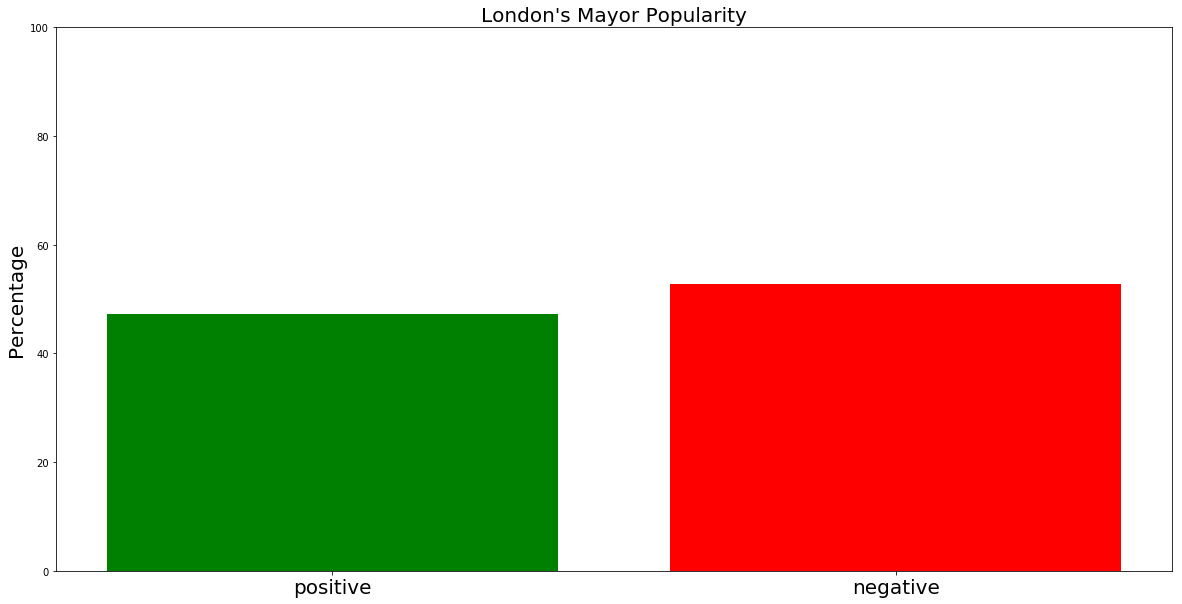

In [111]:
x = np.arange(2)

sentiments = [100*number_pos/(number_pos+number_neg), 100*number_neg/(number_pos+number_neg)]

fig, ax = plt.subplots(figsize=(20,10))
pos, neg = plt.bar(x, sentiments)
pos.set_facecolor('g')
neg.set_facecolor('r')
ax.set_ylim([0, 100])
ax.set_ylabel('Percentage',fontsize=20)
ax.set_title("London's Mayor Popularity",fontsize=20)
plt.xticks(x, ('positive', 'negative'),fontsize=20)


plt.show()

In [113]:
fig.savefig('pop.png')

In [112]:
number_neg,number_pos

(6093, 5473)